# Simple Diffusion

This notebook contains all the code needed to train and run a diffusion model that creates numbers

The model will be trained on the MNIST dataset.

The model is implemented with PyTorch. If you are using the Kaggle notebook, all dependencies should have been installed already.

# Overview of Diffusion Models

Diffusion models are a class of generative models, which means they generate data which is simliar to the data they were trained on. They are similar to GANs (Generative Adversarial Networks), but diffusion models rely on a process consisting of destroying data by adding noise, and then reversing this noising process to get a new output. There is a forward process, which consists of adding Gaussian noise to the image, and a reverse process, which consists of trying to recover the image by reversing the noising process.


Diffusion models essentially train a model to generate a model from noise.

There are two parts: the forward noising process and the reverse noising process. 

The forward noising process noises current images, and these are used to train the model.

Here is what the forward noising process looks like:

![seven_noise_large.gif](https://i.imgur.com/mjhRi0V.gif)

![image.png](https://i.imgur.com/Ac0DY9s.png)

The reverse noising process generates images by having a model predict the noise in random noise, and then slowly removes that predicted noise from the image.

# Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import cos, pi
from random import randint

# Helper functions

Contains mostly visualization functions

In [2]:
def display_batch(batch, nrow=8, min=None, max=None):
    if not min:
        min = batch.min()

    if not max:
        max = batch.max()

    batch = (batch - min) / (max - min)
    img = torchvision.utils.make_grid(batch, nrow=nrow)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Forward diffusion

Contains all the functions we need to noise an image

In [3]:
MAX_TIMESTEPS = 1000

## Epsilon

This is the noise that we apply to the image. It is a matrix of values, where
each number is a random number. The probability of getting each number is
based on a normal distribution; Values closer to zero have a higher chance of
getting chosen.

The size of the tensor generated is deteremined by tensor_size

In [4]:
def epsilon(tensor_size):
    std_dev = 0.3 # Sampled values will mostly be between -1 and 1
    return torch.randn(tensor_size) * std_dev

Let's generate four noise examples, and see what it looks like:

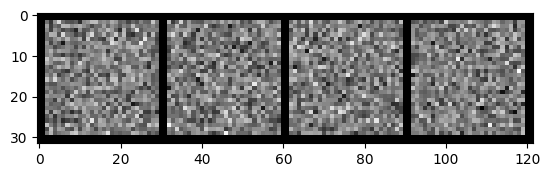

In [5]:
random = epsilon((4, 1, 28, 28))

display_batch(random)

## Alpha, beta, and alpha bar

In the noise process equation, these variables essentially determine **how much to noise
the image** at a particular timestep, t. Lower alpha bar is more noise/less original image.

These variables are used in the noising equation, which is shown later. 

You can modify how alpha bar changes over time to change how quickly the image
gets noisy over time; this is called the **noise schedule**.

In the original diffusion model paper, the researchers used a simple linear
noise schedule.  This is what we will be using in our notebook.

However, linear schedules quickly make the images become very noisy, even though we are nowhere near the max timesteps.

Instead, you may want to look at other schedules, such as a cosine schedule developed by Nichol and Dhariwal's at OpenAI (https://arxiv.org/abs/2102.09672). 

A warning if you want to implement the cosine schedule: We've tried to implement the cosine schedule, and we had the variance of our generated image "explode", reaching hundreds of thousands. If you want to give cosine schedules a try, make sure you implement everything correctly. 

You can see tests between linear vs cosine schedule at
https://hackmd.io/@BaconErie/lin-vs-cos-schedule (might be a bit complicated)

# Alpha and Beta

These variables are also a measure of how noisy the image should be at a particular timestep. Since we are using the scheduling method used by OpenAI, we do not use alpha and beta in the forward diffusion process. However, we will need this in the reverse diffusion process.

In [6]:
def beta(t):
    if t == 0:
        return torch.tensor(0.0001)
    else:
        return torch.tensor(0.0199 * t/MAX_TIMESTEPS + 0.0001)

In [7]:
def alpha(t):
    return 1 - beta(t)

In [8]:
def alpha_bar(t):
    if type(t) != int:
        if type(t) == float:
            t = int(t)
        else:
            t = int(t.item())
    list_of_alphas = torch.tensor([alpha(x) for x in range(t+1)])
    
    return torch.cumprod(list_of_alphas, dim=0)[t]

## Noise function


This is the star of the show, and implements the main noising equation.

Given:

- Batch of images
- Batch of noise
- Timestep t

It will return a batch of noised images that can then be used to train the denoiser model.

The noise function is based on this equation:

$$
x_t = \sqrt{\overline\alpha}x_0 + \sqrt{1 - \overline\alpha_t}\epsilon
$$

Where $x_0$ is the first image, and $x_t$ is the image with the noise added to $t$ timesteps.

In [9]:
def noise(image, noise_sample, t):
    num_rows = len(image)
    num_cols = len(image[0])

    result = torch.sqrt(alpha_bar(t)) * image + torch.sqrt(1 - alpha_bar(t)) * noise_sample

    return torch.clamp(result, min=-1, max=1)

To demonstrate, here we load a batch of images from the MNIST dataset and then show the images, the noise, and then the noised images at timestep t/T = 0.75

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 8078205.26it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1582852.40it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 12332562.50it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2167788.89it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


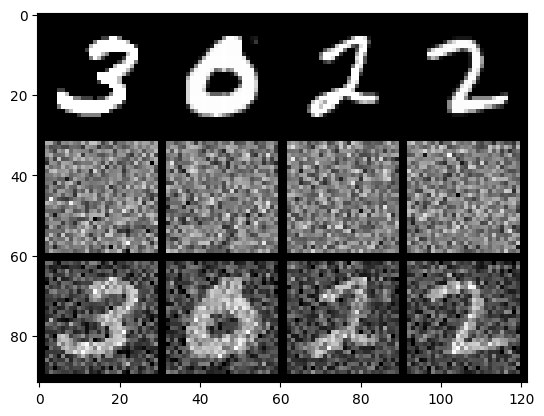

In [10]:
# First, we will transform the images a bit so that we can work with them

class ScaleToMinusOneToOne(object):
    def __call__(self, tensor):
        return tensor * 2.0 - 1.0

transform = transforms.Compose([
    transforms.ToTensor(),          # Convert PIL image to tensor
    ScaleToMinusOneToOne()         # Scale tensor values to range from -1 to 1
])

MNIST_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

MNIST_dataloader = torch.utils.data.DataLoader(MNIST_dataset, batch_size=4,
                                          shuffle=True, num_workers=2)

# Then get some images

images, labels = next(iter(MNIST_dataloader))

# Noise them

noise_sample = epsilon(images.shape)
noised_images = noise(images, noise_sample, torch.tensor(0.4 * MAX_TIMESTEPS))


# Take our images, noise, and noised images and put them into a large batch of images, and then display them
display = torch.cat((images, noise_sample, noised_images), dim=0)

display_batch(display, nrow=4, min=-1, max=1)

# Noise predictor model

Now that we can noise images, it's time to write the code that will turn noise back into images.

We will do this by predicting the noise in a given image, and slowly remove noise from that image.

So first, we need to build a model that can predict the noise.

This is the model that actually predicts the noise, and is the most important component of the reverse diffusion process.

In the original diffusion model paper, a modified UNet is used, and state-of-the-art diffusion programs such as Stable Diffusion build upon the UNet model and change out specific components in the model.

This notebook, however, will use a more simple model to predict noise. Here is an architecture diagram of the model:


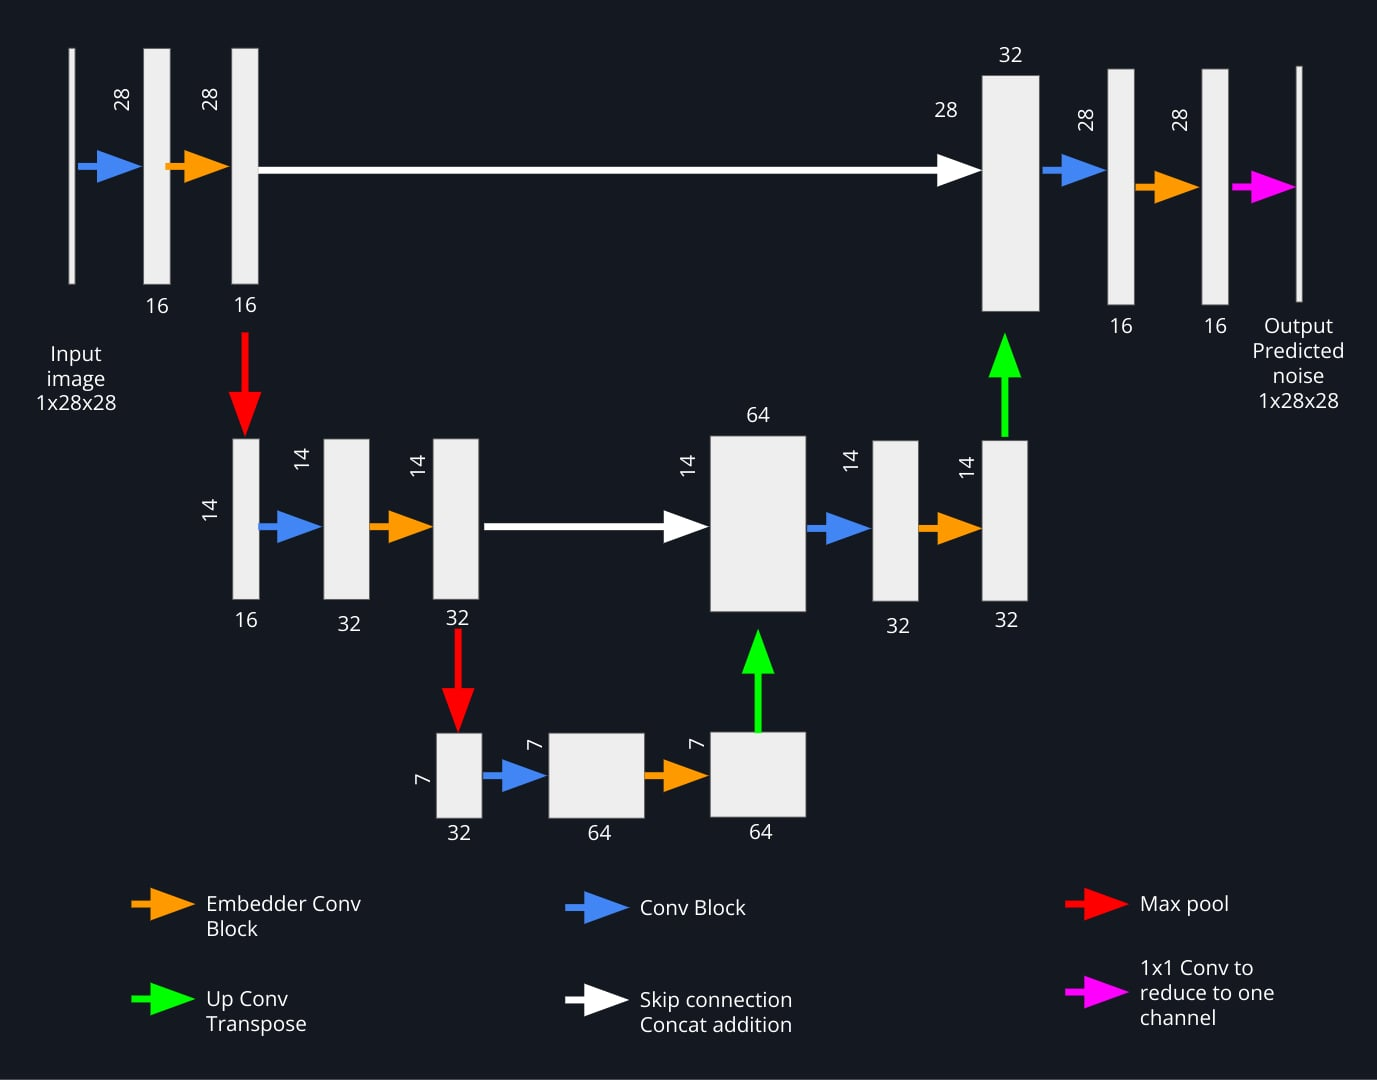

You can see that it is very much similar to a Unet, just with less convolutions and skip connections. It is more simple, and less "woven", and so we call this model the Un-woven Unet, or the UwUnet. Admittedly, its design choices are quite arbitrary, and perhaps doesn't exactly deserve a name, but since we are working with pretty small images and simple images, it should give us results that are somewhat distinctive.

The convolution block is simply a 3x3 kernel convolution that maintains the spatial dimensions of the image while doubling the channels.

The embedder convolution concats the convolution output with channels that just contain the number and timestep information, and then runs a convolution over all the channels. This will hopefully help embed data to the model and give it a better prediction.

The max pool is max pool. If you don't know what that is, it effect is that it halves the spatial dimensions but most importantly keeps only the most important information from the previous filters.

The upconv transpose is just something that will increase the resolution of the image.

Skip connections connects data from the beginning to the end. This is a key part of Unet and similar models, and helps to reduce loss quicker. My understanding is that over many convolutions, the original data gets lost, and so the skip connections helps the model "re-remember" the original data.

Finally, we have a 1x1 Conv that runs through all of the channels to get it back to 1 channel that we can display.

Here is the code for our model:

In [11]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding='same'),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)

    

class Embedder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Embedder, self).__init__()
        
        self.in_channels = in_channels
        self.conv = nn.Conv2d(in_channels=in_channels+2, out_channels=out_channels, kernel_size=3, stride=1, padding='same')
        self.relu = nn.ReLU()
    
    def forward(self, x, t_T, label_tensor):
        timestep_channel = torch.full((x.shape[0], 1, x.shape[2], x.shape[3]), fill_value=t_T, dtype=torch.float32, device=x.device, requires_grad=True)
        
        
        label_filled = []
        for label in label_tensor:
            label_filled.append(torch.full((1, x.shape[2], x.shape[3]), fill_value=label, dtype=torch.float32, device=x.device, requires_grad=True))
        
        label_filled_channel = torch.stack(label_filled)
        
        conv_in = torch.cat((x, timestep_channel, label_filled_channel), dim=1)
        
        return self.relu(self.conv(conv_in))

class NoisePredictor(nn.Module):
    def __init__(self):
        super(NoisePredictor, self).__init__()
        self.conv1 = ConvBlock(in_channels=1, out_channels=16)
        self.embedder1 = Embedder(in_channels=16, out_channels=16)

        self.max_pool1 = nn.MaxPool2d(2)

        # Images should now be 16x14x14

        self.conv2 = ConvBlock(in_channels=16, out_channels=32) # Doubles channel
        self.embedder2 = Embedder(in_channels=32, out_channels=32)

        self.max_pool2 = nn.MaxPool2d(2) # Halves dimension

        # Images should now be 32x7x7

        self.conv3 = ConvBlock(in_channels=32, out_channels=64)
        self.embedder3 = Embedder(in_channels=64, out_channels=64)


        # UPSAMPLING AND CONV #
        # Upsample in channels are double the out channels because we concat
        # the outputs from the decoder blocks

        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        # 32x14x14
        self.conv4 = ConvBlock(in_channels=64, out_channels=32)
        self.embedder4 = Embedder(in_channels=32, out_channels=32)


        self.upconv2 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        # 16x28x28
        self.conv5 = ConvBlock(in_channels=32, out_channels=16)
        self.embedder5 = Embedder(in_channels=16, out_channels=16)

        # Final 1x1 Conv to reduce channels
        self.channel_reduction = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=1, stride=1, padding=0)

    def forward(self, x, t_T, number):
        conv1_out = self.embedder1(self.conv1(x), t_T, number)

        conv2_out = self.embedder2(self.conv2(self.max_pool1(conv1_out)), t_T, number)
        conv3_out = self.embedder3(self.conv3(self.max_pool2(conv2_out)), t_T, number)

        conv4_in = torch.cat((self.upconv1(conv3_out), conv2_out), dim=1)
        conv4_out = self.embedder4(self.conv4(conv4_in), t_T, number)

        conv5_in = torch.cat((self.upconv2(conv4_out), conv1_out), dim=1)
        conv5_out = self.embedder5(self.conv5(conv5_in), t_T, number)

        single_channel = self.channel_reduction(conv5_out)

        return torch.tanh(single_channel)

Let's test the model to make sure the input and output dimensions match.

And, just for fun, let's look at the input images and the output images. Since the model hasn't been trained, all the parameters are random, and so the output images are completely useless.

torch.Size([4, 1, 28, 28])
torch.Size([4, 1, 28, 28])


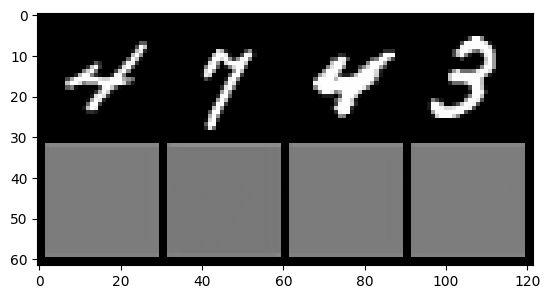

In [12]:
shape_test = NoisePredictor() # Create a new NoisePredictor model

images, labels = next(iter(MNIST_dataloader)) # We will get some images using the dataloader defined above

output = shape_test(images, torch.tensor(0.0), labels.to(torch.float32))

# Print the shapes of the input images and output
# They should match
print(images.shape)
print(output.shape)

display = torch.cat((images, output), dim=0)

display_batch(display, nrow=4, min=-1, max=1)

# Training

Before we can use the diffusion model, we have to train the noise predictor.

## Getting the data

We will use the MNIST dataset to train our model. We will noise the images later on when we train the model.

In [13]:
class ScaleToMinusOneToOne(object):
    def __call__(self, tensor):
        return tensor * 2.0 - 1.0

transform = transforms.Compose([
    transforms.ToTensor(),          # Convert PIL image to tensor
    ScaleToMinusOneToOne()         # Scale tensor values to range from -1 to 1
])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)




testset = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                          shuffle=False, num_workers=2)

# Create a model instance

In [14]:
self_trained_model = NoisePredictor()

# Loss function and optimizer

We used MSE loss and stochastic gradient descent to train the model. You can experiment with other loss functions and see how that changes the accuracy of the model.

In [15]:
criterion = nn.MSELoss()
optimizer = optim.SGD(self_trained_model.parameters(), lr=0.001, momentum=0.9)

## Training loop

Finally, here is the code that actually trains the model.

I've already trained a model, so I've disabled the training code. If you are running this notebook on your own, change the DO_TRAIN variable to true.

In [16]:
DO_TRAIN = False
WEIGHTS_OUTPUT_FILE = 'linear_schedule.pt'

In [17]:
if DO_TRAIN:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self_trained_model.to(device)
    for epoch in range(30):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # Get the images
            images, labels = data

            images = images.to(device) # Move to the GPU if GPU is availible

            # Choose a random timestep
            timestep = randint(0, MAX_TIMESTEPS+1)

            # Noise the images, and also save the noise
            sample_noise = epsilon(images.shape).to(device)
            noised_images = noise(images, sample_noise, torch.tensor(timestep)).to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            predicted_noise = self_trained_model(noised_images, torch.tensor(timestep/MAX_TIMESTEPS), labels).to(device)
            loss = criterion(predicted_noise, sample_noise).to(device)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')

    # Save the model
    torch.save(self_trained_model.state_dict(), WEIGHTS_OUTPUT_FILE)


Let's test the model!

If you trained the model yourself, the code will automatically use the model you trained. Otherwise, it will use a model we trained before hand.

In [18]:
if DO_TRAIN:
    noise_predictor = self_trained_model 
else:
    noise_predictor = NoisePredictor()
    
    if torch.cuda.is_available():
        map_location = 'cuda'
    else:
        map_location = 'cpu'
    
    status = noise_predictor.load_state_dict(torch.load('uwunet_noise_predictor_100_epochs_linear_schedule.pt', map_location=map_location)) # Pretrained model
    print('Using pretrained model!')
    print('Loading status: ', status)

Using pretrained model!
Loading status:  <All keys matched successfully>


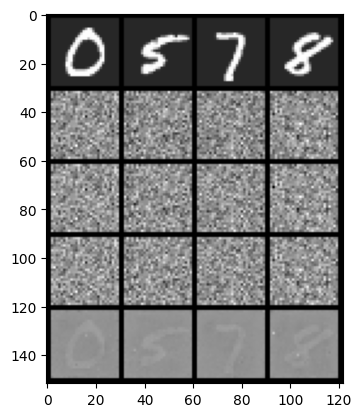

In [19]:
images, labels = next(iter(MNIST_dataloader))
noise_predictor.to('cpu')
noise_sample = epsilon(images.shape)
t_T = 0.75
noised_images = noise(images, noise_sample, torch.tensor(t_T * MAX_TIMESTEPS))
predicted_noise = noise_predictor(noised_images, torch.tensor(t_T),labels)
diff = predicted_noise - noise_sample


display = torch.cat((images, noised_images, noise_sample, predicted_noise, diff), dim=0)
display_batch(display, nrow=4)

Each row means the following:
1. Original image
2. Noised image
3. Actual noise used
4. Predicted noise
5. Difference between predicted noise and actual noise

# Final Denoising 

Finally, we will implement the denoising code and try to generate some images. 

First, we will write our denoising function, which takes in the previous image, the predicted noise, as well as the noise timestep the image currently has.

The denoise function removes noise slowly, following the cosine schedule; it does not remove all the noise predicted by the model.

The denoise function implements the following formula:

$$
x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left(x_t - \frac{\beta_t}{\sqrt{1 - \overline\alpha}} \epsilon_{\theta}(x_t, t) \right) + \sqrt{\beta_t}\epsilon
$$

Where $\epsilon_{\theta}(x_t, t)$ is our model's predicted noise given the previous image $x_t$ and the current timestep $t$

This formula looks super complicated. However, if we look at it, it seems like we are subtracting the current image by the predicted noise times something. The other factor then is based on the beta and alpha, or the schedule we used. We then multiply the more clearer image by some amount and then mix it with a little bit more noise.

The little bit more noise, $\sqrt{\beta_t}\epsilon$, is not added at the last timestep, or when $t = 0$, because then we won't be able to remove it.

In [20]:
def denoise(previous_image, predicted_noise, timestep):
    a_t = alpha(timestep)
    b_t = beta(timestep)

    alpha_bar_t = alpha_bar(timestep)

    alpha_sqrt_inv = 1 / torch.sqrt(a_t)

    remove_amount = b_t / torch.sqrt(1 - alpha_bar_t)
    noise_to_remove = predicted_noise * remove_amount

    if timestep == 0:
        added_noise = 0
    else:
        added_noise = epsilon(previous_image.shape) * torch.sqrt(b_t)

    result =  alpha_sqrt_inv * (previous_image - noise_to_remove) + added_noise
    
    return result

Let's first test this code on some manually noised images. Here, I take an image from the MNIST dataset, noise it to a t/T value of 0.5, and then slowly denoise.

We'll sample images every 0.1 t/T and see how the image changes over time.

Number is 2
t/T: 0.5, 0.4, 0.3, 0.2, 0.1, 0.0


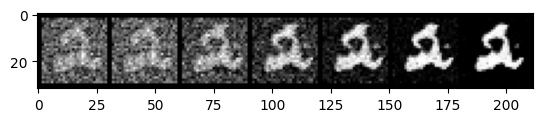

In [21]:
starting_t_T = 0.5 # Play around with this value!

images, labels = next(iter(MNIST_dataloader))

image = images[0].unsqueeze(0)
label = labels[0].unsqueeze(0)

print('Number is ' + str(label.item()))

noise_sample = epsilon(image.shape)
noised_image = noise(image, noise_sample, starting_t_T*MAX_TIMESTEPS)

display = [noised_image]

t_T_label = 't/T: '

for timestep in range(int(starting_t_T*MAX_TIMESTEPS), 0, -1):
    predicted_noise = noise_predictor(noised_image, torch.tensor(timestep/MAX_TIMESTEPS), label)
    slightly_less_noisy = denoise(noised_image, predicted_noise, timestep)
    
    if timestep/MAX_TIMESTEPS * 100 % 10 == 0:
        # Every 0.1 t/T intervals, add the image to the display so that we can look at it later.
        display.append(slightly_less_noisy)
        
        t_T_label += str(format(timestep/MAX_TIMESTEPS, '.1f'))
        
        t_T_label += ', '
    
    noised_image = slightly_less_noisy

display.append(noised_image)
        
t_T_label += str(format(1/MAX_TIMESTEPS, '.1f'))

display_tensor = torch.cat(display, dim=0)

print(t_T_label)
display_batch(display_tensor, min=-1, max=1)

Let's finally try to generate some numbers! We will essentially do the same thing as the above code, except instead of starting from a noised image, we will start from pure noise.

t/T: 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0


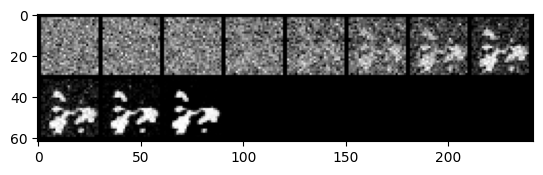

In [22]:
number_to_generate = 7 # Play around with this value!

noise_sample = epsilon(image.shape)
noised_image = noise_sample

display = [noised_image]

t_T_label = 't/T: '

for timestep in range(int(MAX_TIMESTEPS-1),0, -1):
    predicted_noise = noise_predictor(noised_image, torch.tensor(timestep/MAX_TIMESTEPS), torch.tensor(number_to_generate).unsqueeze(0))
    slightly_less_noisy = denoise(noised_image, predicted_noise, timestep)
    
    if timestep/MAX_TIMESTEPS * 100 % 10 == 0:
        # Every 0.1 t/T intervals, add the image to the display so that we can look at it later.
        display.append(slightly_less_noisy)
        
        t_T_label += str(format(timestep/MAX_TIMESTEPS, '.1f'))
        
        t_T_label += ', '
    
    noised_image = slightly_less_noisy

display.append(noised_image)
        
t_T_label += str(format(1/MAX_TIMESTEPS, '.1f'))

display_tensor = torch.cat(display, dim=0)

print(t_T_label)
display_batch(display_tensor, min=-1, max=1)

As you can see, we do generate something, and the values of the image don't explode over time. However, what we have generated is not very good.

There are many ways to improve this model:

- Change the noise predictor architecture; the original diffusion models used other forms of embedding and also had transformer layers, which would improve the accuracy of the predictor model and thus also the reverse diffusion process overall. 

- Use a cosine schedule: Instead of training mostly on noisy images, change the schedule from linear to cosine to reduce how quickly the image gets noised. (WARNING: We've tried this notebook before with a cosine schedule, and the variance of the generated image "explodes". It seems like other people have also encountered this problem, see https://github.com/openai/improved-diffusion/issues/105)

# Sources and Further reading

The following articles simplify the original paper and were helpful for us with making our model:

- [Step by Step visual introduction to Diffusion Models by Kemal Erdem](https://erdem.pl/2023/11/step-by-step-visual-introduction-to-diffusion-models)
- [The Annotated Diffusion Model Niels Rogge and Kashif Rasul on HF](https://huggingface.co/blog/annotated-diffusion)

The papers are of course helpful if you understand the math:
- [Deep Unsupervised Learning using Nonequilibrium Thermodynamics by Sohl-Dickstein et al.](https://arxiv.org/abs/1503.03585): Introduced the concepts of diffusion
- [Denoising Diffusion Probabilistic Models by Ho et al.](https://arxiv.org/abs/2006.11239): Provides the basis for implementing diffusion models 
- [High-Resolution Image Synthesis with Latent Diffusion Models by Rombach et al.](https://arxiv.org/abs/2112.10752): Improves on diffusion models by keeping everything in the "latent space"; iirc works on embeddings instead of entire images, so it's faster
- [Improved Denoising Diffusion Probabilistic Models by Nicol and Dhariwal](https://arxiv.org/abs/2102.09672): Introduces the cosine schedule used here as well as other improvements